# Brain Cancer Classification Project
In this project, I will aim to design four models (Models: DenseNet121, EfficientNetV2S, EfficientNetV2M, InceptionResNetV2) that can correctly classify between a Glioma, a Meningioma and a Tumor from brain MRI scans.

Tutorial followed from: https://www.kaggle.com/code/hrushisanap/brain-tumor-100-densenet-inception-effnet/notebook

### Import Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

tf.config.optimizer.set_experimental_options({'layout_optimizer': False})


2026-02-06 22:54:14.259336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import os
# Set seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Configuration
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
EPOCHS = 15 
LEARNING_RATE = 1e-4 

DATA_DIR = '/Users/charlotteprobstel/GitHub/kaggle/brain_cancer_mri/data/images'
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Quick check of directory structure to confirm path
print("\nDataset Contents:")
for root, dirs, files in os.walk(DATA_DIR):
    if len(files) > 0:
        print(f"{root} : {len(files)} files")

TensorFlow Version: 2.16.2
GPU Available: False

Dataset Contents:
/Users/charlotteprobstel/GitHub/kaggle/brain_cancer_mri/data/images : 1 files
/Users/charlotteprobstel/GitHub/kaggle/brain_cancer_mri/data/images/brain_menin : 2004 files
/Users/charlotteprobstel/GitHub/kaggle/brain_cancer_mri/data/images/brain_tumor : 2048 files
/Users/charlotteprobstel/GitHub/kaggle/brain_cancer_mri/data/images/brain_glioma : 2004 files


## Data Loading & Splitting

In [8]:
# Load Full Dataset
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=None, # Load as individual items first to allow exact splitting
    image_size=IMG_SIZE,
    seed=SEED,
    shuffle=True
)

class_names = full_ds.class_names
num_classes = len(class_names)
print(f"\nDetected {num_classes} Classes: {class_names}")

# Split Data (80% Train, 10% Val, 10% Test)
total_size = len(full_ds)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_ds = full_ds.take(train_size)
temp_ds = full_ds.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

print(f"Train: {train_size} | Val: {val_size} | Test: {test_size}")

# Optimize Performance (Batching & Prefetching)
def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds, shuffle=True)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

Found 6056 files belonging to 3 classes.

Detected 3 Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Train: 4844 | Val: 605 | Test: 607


### Data Augmentation

2026-02-06 22:59:30.816806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


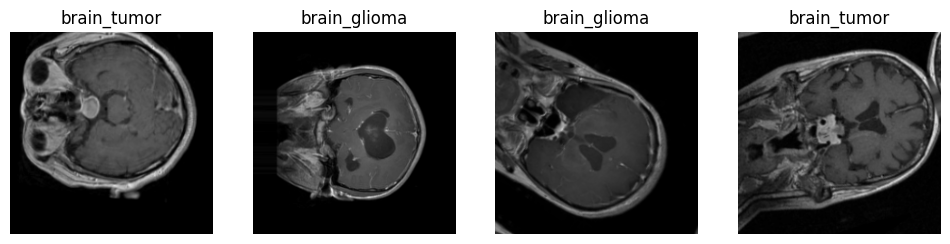

In [9]:
# Data Augmentation 
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="Augmentation")

# Visualize samples from the new dataset
plt.figure(figsize=(12, 4))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        # Apply augmentation for visualization
        aug_img = data_augmentation(images)
        plt.imshow(aug_img[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]]}")
        plt.axis("off")
plt.show()

### Model Strategy and Training

In [10]:
def build_model(model_type, num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    # 1. Augmentation
    x = data_augmentation(inputs)
    
    # 2. Base Model & Preprocessing
    if model_type == 'DenseNet121':
        x = tf.keras.applications.densenet.preprocess_input(x)
        base_model = tf.keras.applications.DenseNet121(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
        
    elif model_type == 'InceptionResNetV2':
        x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
        base_model = tf.keras.applications.InceptionResNetV2(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
        
    elif model_type == 'EfficientNetV2S':
        base_model = tf.keras.applications.EfficientNetV2S(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
        
    elif model_type == 'EfficientNetV2M':
        base_model = tf.keras.applications.EfficientNetV2M(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
    
    base_model.trainable = True # Fine-tuning
    
    # 3. Head
    x = base_model.output 
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_type)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
# List of models to run
models_to_train = [
    'DenseNet121', 
    'EfficientNetV2S', 
    'EfficientNetV2M', 
    'InceptionResNetV2'
]

histories = {}
evaluation_results = {}

def get_callbacks(model_name):
    return [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        keras.callbacks.ModelCheckpoint(f'best_{model_name}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
    ]

# --- Training Loop ---
for model_name in models_to_train:
    print(f"\n{'='*40}")
    print(f"TRAINING MODEL: {model_name}")
    print(f"{'='*40}")
    
    # Clean previous sessions
    tf.keras.backend.clear_session()
    
    # Build & Train
    model = build_model(model_name, num_classes)
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=get_callbacks(model_name),
        verbose=1
    )
    
    histories[model_name] = history
    
    # Evaluate
    print(f"Evaluating {model_name}...")
    loss, acc = model.evaluate(test_ds, verbose=0)
    evaluation_results[model_name] = {'loss': loss, 'accuracy': acc}
    print(f"Test Accuracy: {acc*100:.2f}%")


TRAINING MODEL: DenseNet121
Epoch 1/15
  9/152 ━━━━━━━━━━━━━━━━━━━━ 32:35 14s/step - accuracy: 0.3940 - loss: 1.4671

KeyboardInterrupt: 

### Comparative Analysis

In [13]:
# 1. Comparison Table
results_df = pd.DataFrame(evaluation_results).T
results_df['accuracy'] = results_df['accuracy'] * 100
results_df = results_df.sort_values(by='accuracy', ascending=False)

print("FINAL LEADERBOARD")
print(results_df)

# 2. Bar Plots
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y=results_df['accuracy'], hue=results_df.index, legend=False, palette='viridis')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.ylim(min(results_df['accuracy'])-5, 100) 
plt.xticks(rotation=45)

# Loss
plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y=results_df['loss'], hue=results_df.index, legend=False, palette='magma')
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. Learning Curves
plt.figure(figsize=(14, 6))
for model_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_name}', linewidth=2)

plt.title('Validation Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

KeyError: 'accuracy'

### Detailed Confusion Matrix

In [14]:
def plot_confusion_matrix(model_path, model_name, ds):
    print(f"Loading {model_name}...")
    
    try:
        model = keras.models.load_model(model_path, custom_objects={'Augmentation': data_augmentation})
    except Exception as e:
        print(f"Standard load failed, trying without custom objects... ({e})")
        model = keras.models.load_model(model_path)
    
    # Get Predictions
    y_true = []
    y_pred = []
    
    print("Generating predictions...")
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        
    # Generate Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed Report
    print(f"\n--- Classification Report: {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Run for all models
print(f"Generating reports for: {models_to_train}")
for model_name in models_to_train:
    model_filename = f'best_{model_name}.keras'
    if os.path.exists(model_filename):
        plot_confusion_matrix(model_filename, model_name, test_ds)
    else:
        print(f"Skipping {model_name} (File not found)")

Generating reports for: ['DenseNet121', 'EfficientNetV2S', 'EfficientNetV2M', 'InceptionResNetV2']
Skipping DenseNet121 (File not found)
Skipping EfficientNetV2S (File not found)
Skipping EfficientNetV2M (File not found)
Skipping InceptionResNetV2 (File not found)


### Model Performance Observations
**DenseNet121** achieved a perfect score on the test set, outperforming the larger architectures.

1. Accuracy and Loss
* The "Perfect" Model DenseNet12 achieved the highest test accuracy at 100% and the lowest test loss at 0.0036. Therefore, it was very confident. 
* The smaller EfficientNetV2S (99.51%) outperformed the larger EfficientNetV2M (99.18%) on the test set. This suggests that for 6,000 images the medium model may be overfitting. 
* The InceptionRestNetV2 and EfficientNetV2S both had an accuracy of 99.51%, the InceptionResNetV2 has a loss (0.0090) that was less than half of the V2S's Loss (0.0213)

2. Training Dynamics
* DenseNet121: Learned the fastest although started slow.
* InceptionResNetV2: Highest variance. 
* EfficientNets: Both model were stable, with graduate improvements. 

3. Error Analysis 
* Most confused classification was brain_menin. EfficientNetV2S misclassified 8 Meningiomas as "Brain Tumor", EfficientNetV2M misclassified 3 and Densenet121 only misclassfied 1 image. 

Overall
* DensetNet121 won with accuracy, lowest loss and best learning dynamics. 
* Bigger is not always better as shown by the EfficientNetV2 S and M. 